<a href="https://colab.research.google.com/github/ridvanyigit/Tensorflow-2.0/blob/main/244329064_ridvanyigit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.18.0-rc0
!pip install mlxtend==0.17.0
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 2.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.18.0rc0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.18.0rc0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.18.0rc0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.23.4
    Uninstalling mlxtend-0.23.4:
      Successfully uninstalled mlxtend-0.2

In [20]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings('ignore')
tf.__version__

from tensorflow.keras.datasets import cifar10
import optuna
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score

array([[3],
       [8],
       [8],
       [0],
       [6],
       [6],
       [1],
       [6],
       [3],
       [1],
       [0],
       [9],
       [5],
       [7],
       [9],
       [8],
       [5],
       [7],
       [8],
       [6],
       [7],
       [0],
       [4],
       [9],
       [5],
       [2],
       [4],
       [0],
       [9],
       [6],
       [6],
       [5],
       [4],
       [5],
       [9],
       [2],
       [4],
       [1],
       [9],
       [5],
       [4],
       [6],
       [5],
       [6],
       [0],
       [9],
       [3],
       [9],
       [7],
       [6],
       [9],
       [8],
       [0],
       [3],
       [8],
       [8],
       [7],
       [7],
       [4],
       [6],
       [7],
       [3],
       [6],
       [3],
       [6],
       [2],
       [1],
       [2],
       [3],
       [7],
       [2],
       [6],
       [8],
       [8],
       [0],
       [2],
       [9],
       [3],
       [3],
       [8],
       [8],
       [1],
       [1],
    

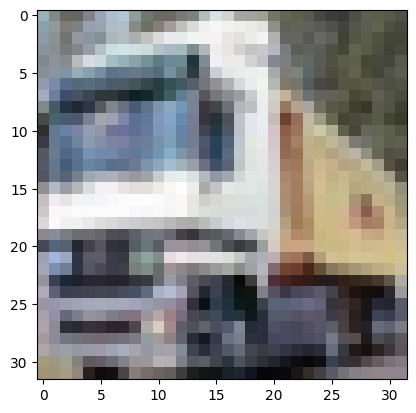

In [21]:
# Load and preprocess data
(X_train, y_train),(X_test, y_test) = cifar10.load_data()

classes_name = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

X_train.max()

X_train = X_train/255
X_test = X_test/255

X_train.shape

X_test.shape

plt.imshow(X_train[1])

y_test

In [22]:
# Define the original (unoptimized) model
def create_original_model():
    model = Sequential()

    model.add(Conv2D(
        filters=32,
        kernel_size=(3,3),
        padding='same',
        activation='relu',
        input_shape=(32,32,3)))

    model.add(Conv2D(
        filters=32,
        kernel_size=(3,3),
        padding='same',
        activation='relu'))

    model.add(MaxPool2D(
        pool_size=(2,2),
        strides=2,
        padding='valid'))

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=10, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [23]:
# Define the model creation function with Optuna hyperparameters
def create_model(trial):
    # Hyperparameter suggestions using trial.suggest_* methods
    n_filters_conv1 = trial.suggest_categorical('n_filters_conv1', [32, 64, 128])
    n_filters_conv2 = trial.suggest_categorical('n_filters_conv2', [32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)
    n_units_dense = trial.suggest_categorical('n_units_dense', [64, 128, 256])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    model = Sequential()

    model.add(
        Conv2D(
            filters=n_filters_conv1,
            kernel_size=(3,3),
            padding='same',
            activation='relu',
            input_shape=(32,32,3)
        )
    )
    model.add(
        Conv2D(
            filters=n_filters_conv2,
            kernel_size=(3,3),
            padding='same',
            activation='relu'
        )
    )
    model.add(MaxPool2D(
        pool_size=(2,2),
        strides=2,
        padding='valid'))

    model.add(Dropout(dropout_rate))

    model.add(Flatten())

    model.add(Dense(units=n_units_dense, activation='relu'))
    model.add(Dense(units=10, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [26]:
# Define the objective function for Optuna
def objective(trial):
    model = create_model(trial)
    #model.summary()

    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=5,
        verbose=1,
        validation_data=(X_test, y_test)
    )

    # Get validation accuracy from the last epoch
    val_loss = history.history['val_loss'][-1]

    return val_loss # We are minimizing the loss, not maximizing the accuracy.

In [27]:
# Run Optuna optimization
study = optuna.create_study(direction='minimize') # Changed direction to minimize.
study.optimize(objective, n_trials=10) # Reduced the trial count for faster execution.


print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-04-20 20:28:17,442] A new study created in memory with name: no-name-c1739ca0-b7b1-4158-b7f7-4658e8aea492


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.2718 - loss: 2.0270 - val_accuracy: 0.4569 - val_loss: 1.5839
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.4572 - loss: 1.5616 - val_accuracy: 0.5008 - val_loss: 1.4312
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.4996 - loss: 1.4213 - val_accuracy: 0.5281 - val_loss: 1.3494
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.5361 - loss: 1.3290 - val_accuracy: 0.5486 - val_loss: 1.2787
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.5607 - loss: 1.2573 - val_accuracy: 0.5717 - val_loss: 1.2247


[I 2025-04-20 20:29:44,782] Trial 0 finished with value: 1.2246540784835815 and parameters: {'n_filters_conv1': 128, 'n_filters_conv2': 128, 'dropout_rate': 0.5946238920392568, 'n_units_dense': 128, 'learning_rate': 1.736626879540003e-05}. Best is trial 0 with value: 1.2246540784835815.


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.3731 - loss: 1.7136 - val_accuracy: 0.5461 - val_loss: 1.2800
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.5498 - loss: 1.2603 - val_accuracy: 0.5956 - val_loss: 1.1501
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6059 - loss: 1.1145 - val_accuracy: 0.6194 - val_loss: 1.0661
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6373 - loss: 1.0167 - val_accuracy: 0.6349 - val_loss: 1.0380
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6651 - loss: 0.9499 - val_accuracy: 0.6430 - val_loss: 1.0065


[I 2025-04-20 20:30:46,345] Trial 1 finished with value: 1.0064687728881836 and parameters: {'n_filters_conv1': 128, 'n_filters_conv2': 32, 'dropout_rate': 0.2818860986932267, 'n_units_dense': 64, 'learning_rate': 0.0014022041969912315}. Best is trial 1 with value: 1.0064687728881836.


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.3602 - loss: 1.7647 - val_accuracy: 0.5598 - val_loss: 1.2382
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.5604 - loss: 1.2371 - val_accuracy: 0.6178 - val_loss: 1.0859
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6113 - loss: 1.1102 - val_accuracy: 0.6488 - val_loss: 1.0076
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6444 - loss: 1.0129 - val_accuracy: 0.6571 - val_loss: 0.9786
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6673 - loss: 0.9504 - val_accuracy: 0.6716 - val_loss: 0.9281


[I 2025-04-20 20:31:46,954] Trial 2 finished with value: 0.9280723929405212 and parameters: {'n_filters_conv1': 128, 'n_filters_conv2': 32, 'dropout_rate': 0.5985680430414954, 'n_units_dense': 128, 'learning_rate': 0.00018900225401194954}. Best is trial 2 with value: 0.9280723929405212.


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.2656 - loss: 2.0319 - val_accuracy: 0.4334 - val_loss: 1.6098
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4413 - loss: 1.5902 - val_accuracy: 0.4782 - val_loss: 1.4819
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4768 - loss: 1.4813 - val_accuracy: 0.4989 - val_loss: 1.4095
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5063 - loss: 1.4054 - val_accuracy: 0.5311 - val_loss: 1.3364
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5327 - loss: 1.3375 - val_accuracy: 0.5487 - val_loss: 1.2961


[I 2025-04-20 20:32:45,698] Trial 3 finished with value: 1.2960611581802368 and parameters: {'n_filters_conv1': 64, 'n_filters_conv2': 64, 'dropout_rate': 0.5711555690185963, 'n_units_dense': 256, 'learning_rate': 1.8998912760782728e-05}. Best is trial 2 with value: 0.9280723929405212.


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3876 - loss: 1.6666 - val_accuracy: 0.5982 - val_loss: 1.1573
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6033 - loss: 1.1172 - val_accuracy: 0.6326 - val_loss: 1.0438
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6505 - loss: 0.9810 - val_accuracy: 0.6511 - val_loss: 0.9766
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6903 - loss: 0.8732 - val_accuracy: 0.6604 - val_loss: 0.9844
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7147 - loss: 0.8067 - val_accuracy: 0.6634 - val_loss: 0.9588


[I 2025-04-20 20:33:43,551] Trial 4 finished with value: 0.958754301071167 and parameters: {'n_filters_conv1': 32, 'n_filters_conv2': 32, 'dropout_rate': 0.49193715793156484, 'n_units_dense': 256, 'learning_rate': 0.0020771860721318933}. Best is trial 2 with value: 0.9280723929405212.


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.1010 - loss: 2.3061 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.0980 - loss: 2.3031 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.1057 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.0998 - loss: 2.3032 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.0995 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3027


[I 2025-04-20 20:34:44,215] Trial 5 finished with value: 2.302713394165039 and parameters: {'n_filters_conv1': 128, 'n_filters_conv2': 32, 'dropout_rate': 0.41945637784965073, 'n_units_dense': 64, 'learning_rate': 0.002874536247853774}. Best is trial 2 with value: 0.9280723929405212.


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.3508 - loss: 1.7845 - val_accuracy: 0.5248 - val_loss: 1.3230
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.5355 - loss: 1.3021 - val_accuracy: 0.5713 - val_loss: 1.2072
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5833 - loss: 1.1678 - val_accuracy: 0.5929 - val_loss: 1.1423
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6074 - loss: 1.1033 - val_accuracy: 0.6064 - val_loss: 1.1065
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6307 - loss: 1.0433 - val_accuracy: 0.6104 - val_loss: 1.1057


[I 2025-04-20 20:35:48,735] Trial 6 finished with value: 1.1056993007659912 and parameters: {'n_filters_conv1': 128, 'n_filters_conv2': 32, 'dropout_rate': 0.21562644074042248, 'n_units_dense': 64, 'learning_rate': 0.0016118673377314143}. Best is trial 2 with value: 0.9280723929405212.


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.3192 - loss: 1.8851 - val_accuracy: 0.4608 - val_loss: 1.4713
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4447 - loss: 1.5296 - val_accuracy: 0.4777 - val_loss: 1.4412
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4925 - loss: 1.4177 - val_accuracy: 0.5158 - val_loss: 1.3693
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5251 - loss: 1.3401 - val_accuracy: 0.5350 - val_loss: 1.2980
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5361 - loss: 1.3021 - val_accuracy: 0.5638 - val_loss: 1.2265


[I 2025-04-20 20:36:52,798] Trial 7 finished with value: 1.226455807685852 and parameters: {'n_filters_conv1': 32, 'n_filters_conv2': 128, 'dropout_rate': 0.4087898569158557, 'n_units_dense': 64, 'learning_rate': 0.005031840326263888}. Best is trial 2 with value: 0.9280723929405212.


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.3018 - loss: 1.9496 - val_accuracy: 0.4693 - val_loss: 1.5213
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4790 - loss: 1.4873 - val_accuracy: 0.5178 - val_loss: 1.3769
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5280 - loss: 1.3561 - val_accuracy: 0.5414 - val_loss: 1.3003
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5517 - loss: 1.2780 - val_accuracy: 0.5752 - val_loss: 1.2300
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5825 - loss: 1.2073 - val_accuracy: 0.5863 - val_loss: 1.1843


[I 2025-04-20 20:37:55,717] Trial 8 finished with value: 1.1842641830444336 and parameters: {'n_filters_conv1': 32, 'n_filters_conv2': 64, 'dropout_rate': 0.3054112536744705, 'n_units_dense': 256, 'learning_rate': 2.7513387525119825e-05}. Best is trial 2 with value: 0.9280723929405212.


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.3781 - loss: 1.7264 - val_accuracy: 0.5517 - val_loss: 1.2682
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5723 - loss: 1.1949 - val_accuracy: 0.6116 - val_loss: 1.0861
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6250 - loss: 1.0583 - val_accuracy: 0.6369 - val_loss: 1.0215
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.6503 - loss: 0.9832 - val_accuracy: 0.6230 - val_loss: 1.0551
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6682 - loss: 0.9313 - val_accuracy: 0.6419 - val_loss: 1.0209


[I 2025-04-20 20:39:34,161] Trial 9 finished with value: 1.020912766456604 and parameters: {'n_filters_conv1': 128, 'n_filters_conv2': 128, 'dropout_rate': 0.2066777211473716, 'n_units_dense': 64, 'learning_rate': 0.0021033359485554924}. Best is trial 2 with value: 0.9280723929405212.


Number of finished trials:  10
Best trial:
  Value:  0.9280723929405212
  Params: 
    n_filters_conv1: 128
    n_filters_conv2: 32
    dropout_rate: 0.5985680430414954
    n_units_dense: 128
    learning_rate: 0.00018900225401194954


In [29]:
# Train and evaluate BOTH original and optimized models
# Create and train the original model
original_model = create_original_model()
original_history = original_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data=(X_test, y_test))
original_loss, original_accuracy = original_model.evaluate(X_test, y_test, verbose=1)

# Create and train the optimized model
optimized_model = create_model(trial)  # Use the best trial from Optuna
optimized_model.compile(
    optimizer=Adam(learning_rate=trial.params['learning_rate']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
optimized_history = optimized_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data=(X_test, y_test))
optimized_loss, optimized_accuracy = optimized_model.evaluate(X_test, y_test, verbose=1)

print("Original Model - Test accuracy: {:.4f}, Test loss: {:.4f}".format(original_accuracy, original_loss))
print("Optimized Model - Test accuracy: {:.4f}, Test loss: {:.4f}".format(optimized_accuracy, optimized_loss))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.4129 - loss: 1.6285 - val_accuracy: 0.6073 - val_loss: 1.1300
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6104 - loss: 1.0983 - val_accuracy: 0.6574 - val_loss: 0.9792
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6638 - loss: 0.9524 - val_accuracy: 0.6795 - val_loss: 0.9222
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6969 - loss: 0.8585 - val_accuracy: 0.6873 - val_loss: 0.9076
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7247 - loss: 0.7804 - val_accuracy: 0.6901 - val_loss: 0.8934
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7428 - loss: 0.7214 - val_accuracy: 0.7063 - val_loss: 0.8462
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7670 - loss: 0.6601 - val_accuracy: 0.7041 - val_loss: 0.8508
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7787 - loss: 0.6182

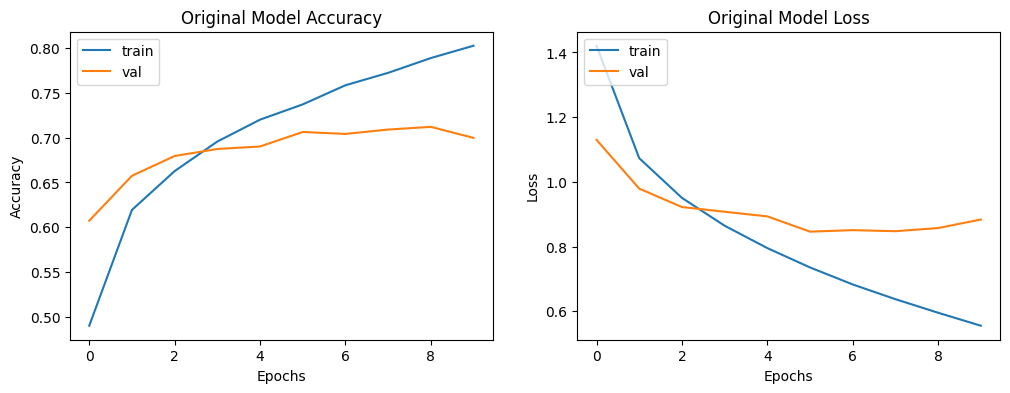

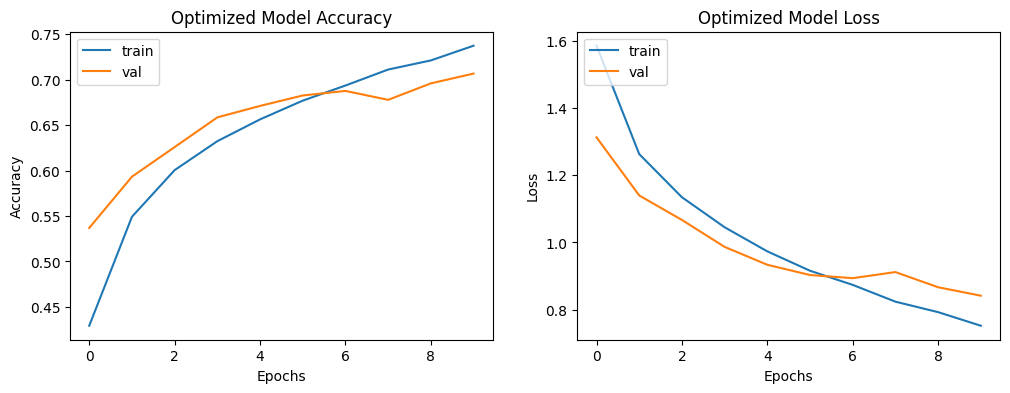

In [30]:
# Plot training and validation accuracy/loss
# Plotting for Original Model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(original_history.history['accuracy'])
plt.plot(original_history.history['val_accuracy'])
plt.title('Original Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(original_history.history['loss'])
plt.plot(original_history.history['val_loss'])
plt.title('Original Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting for Optimized Model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(optimized_history.history['accuracy'])
plt.plot(optimized_history.history['val_accuracy'])
plt.title('Optimized Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(optimized_history.history['loss'])
plt.plot(optimized_history.history['val_loss'])
plt.title('Optimized Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


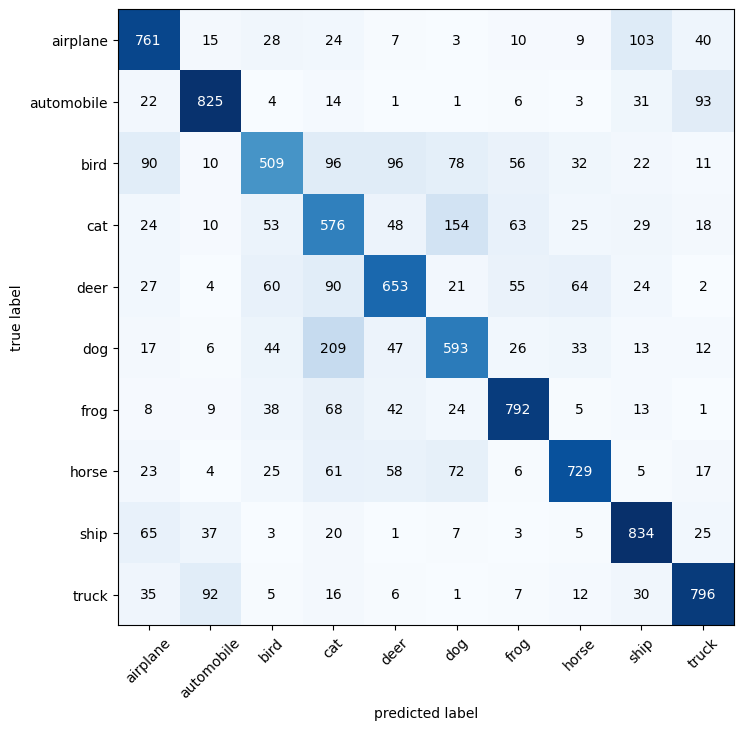

In [31]:
# Confusion Matrix for Optimized Model (Optional)
y_pred = optimized_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

np.set_printoptions(precision=2, threshold=np.inf)
concatenated_array = np.concatenate((y_pred_classes.reshape(len(y_pred_classes),1), y_test.reshape(len(y_test),1)),1)
#print(concatenated_array[:50])

accuracy_score(y_test, y_pred_classes)

cm = confusion_matrix(y_test, y_pred_classes)
#cm

plot_confusion_matrix(conf_mat=cm, figsize=(12,8), class_names=classes_name)
plt.show()